## 06 Pycaret Model

**Project:** UK Housing Price Paid Records

**Purpose:**

**Team Member(s):** Tymo Verhaegen

**Date Last Run:** 07/11/2025

---

In [30]:
%pip install pycaret
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from pycaret.regression import *
import pandas as pd

In [32]:
# Define the path to your model-ready file
file_path = './../../data/housing/processed/price_paid_model_ready.parquet'

print("1. Loading Data...")
data = pd.read_parquet(file_path)
print(f"   -> Data loaded successfully. Shape: {data.shape}")

1. Loading Data...
   -> Data loaded successfully. Shape: (22480822, 10)


In [33]:
print("2. Cleaning Columns (The Fix)...")

# 1. REMOVE POISON COLUMNS
# We search for any column name containing these words and drop it.
ban_list = ['ppd', 'record_status', 'category_type']
cols_to_drop = []

for col in data.columns:
    for ban_word in ban_list:
        if ban_word in col:
            cols_to_drop.append(col)
            break

if cols_to_drop:
    print(f"   -> 💥 Removing problematic columns: {cols_to_drop}")
    data = data.drop(columns=cols_to_drop)
else:
    print("   -> No obvious poison columns found (Data might already be clean).")

# 2. RENAME COLUMNS
# Ensures standard naming for 'town_city' and 'old_new'
data = data.rename(columns={
    'town/city': 'town_city',
    'old/new': 'old_new'
})

2. Cleaning Columns (The Fix)...
   -> 💥 Removing problematic columns: ['record_status___monthly_file_only']


In [34]:
print("3. Filtering and Feature Engineering...")

# 1. FILTER PRICES (Real Market Only)
# Removes errors/peppercorn rents (<£5k) and extreme luxury (>£20m)
print(f"   -> Original Row Count: {len(data)}")
data = data[(data['price'] > 5000) & (data['price'] < 20000000)]
print(f"   -> Row Count after Price Filter: {len(data)}")

# 2. EXTRACT SEASONALITY
# Create 'sale_month' if it doesn't exist
if 'sale_month' not in data.columns:
    data['sale_month'] = data['sale_date'].dt.month
    print("   -> 'sale_month' column created.")

3. Filtering and Feature Engineering...
   -> Original Row Count: 22480822
   -> Row Count after Price Filter: 22478705
   -> 'sale_month' column created.


In [35]:
print("4. Creating Sample...")

# 5% Sample with a fixed random state for reproducibility
data_subset = data.sample(frac=0.05, random_state=42)

print(f"   -> Full Data: {data.shape}")
print(f"   -> Subset for PyCaret: {data_subset.shape}")

4. Creating Sample...
   -> Full Data: (22478705, 10)
   -> Subset for PyCaret: (1123935, 10)


In [36]:
print("5. Initializing Setup...")

# 1. BUILD DYNAMIC CATEGORICAL LIST
# We check which columns actually survived Step 2
potential_cats = ['property_type', 'old_new', 'duration', 'town_city', 'district', 'county']
actual_cats = [c for c in potential_cats if c in data_subset.columns]
print(f"   -> Categorical Features being used: {actual_cats}")

# 2. RUN SETUP
s = setup(
    data = data_subset,
    target = 'price', 
    session_id = 42,
    html = False,
    
    # A. Ignore Dates (The model uses 'sale_year' and 'sale_month' instead)
    ignore_features = ['sale_date'],
    
    # B. Categoricals
    categorical_features = actual_cats,
    
    # C. High Cardinality Fix (For Town/City)
    max_encoding_ohe = 20, 
    
    # D. Math & Cleaning
    transform_target = True,   # Fixes the skewed prices
    remove_outliers = True,    # NOW SAFE TO RUN!
    outliers_threshold = 0.05,
    normalize = True,
    imputation_type = 'simple'
)

print("   -> Setup Complete!")

5. Initializing Setup...
   -> Categorical Features being used: ['property_type', 'old_new', 'duration', 'town_city', 'district', 'county']
                    Description             Value
0                    Session id                42
1                        Target             price
2                   Target type        Regression
3           Original data shape     (1123935, 10)
4        Transformed data shape     (1084598, 13)
5   Transformed train set shape      (747417, 13)
6    Transformed test set shape      (337181, 13)
7               Ignore features                 1
8              Numeric features                 2
9          Categorical features                 6
10     Rows with missing values              0.0%
11                   Preprocess              True
12              Imputation type            simple
13           Numeric imputation              mean
14       Categorical imputation              mode
15     Maximum one-hot encoding                20
16        

In [37]:
print("6. Training Models...")

# Compare models and sort by RMSE (Lower is better)
best_model = compare_models(
    fold = 3, 
    sort = 'RMSE', 
    include = ['lightgbm', 'xgboost', 'rf', 'et', 'dt'] 
)

print(best_model)

6. Training Models...


                                    Model         MAE           MSE  \
xgboost         Extreme Gradient Boosting  53562.1805  3.785117e+10   
lightgbm  Light Gradient Boosting Machine  54508.9864  3.873058e+10   
dt                Decision Tree Regressor  74375.2558  6.522316e+10   

                 RMSE      R2   RMSLE    MAPE  TT (Sec)  
xgboost   194546.7305  0.3807  0.3926  0.3074    9.9533  
lightgbm  196794.8236  0.3664  0.3991  0.3136   11.4800  
dt        255068.1470 -0.0678  0.5223  0.4563    8.1433  
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
   

In [38]:
save_model(best_model, '../../data/trained_models/housing/pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['sale_year', 'sale_month'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['property_type'...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                         


7. Evaluating Best Model on Hold-Out Set...
                       Model         MAE           MSE         RMSE      R2  \
0  Extreme Gradient Boosting  52878.6571  3.811285e+10  195225.1274  0.3667   

    RMSLE    MAPE  
0  0.3912  0.3055  
         property_type old_new   duration   town_city  \
2080975              T       N   Freehold  MANCHESTER   
22085738             T       N   Freehold  COLCHESTER   
11658700             S       N   Freehold     LEISTON   
19536957             D       N   Freehold     CHESTER   
20502575             F       N  Leasehold  BIRMINGHAM   

                           district                     county  sale_year  \
2080975                  MANCHESTER         GREATER MANCHESTER       1997   
22085738                  BRAINTREE                      ESSEX       2016   
11658700            SUFFOLK COASTAL                    SUFFOLK       2005   
19536957  CHESHIRE WEST AND CHESTER  CHESHIRE WEST AND CHESTER       2014   
20502575                 BIR

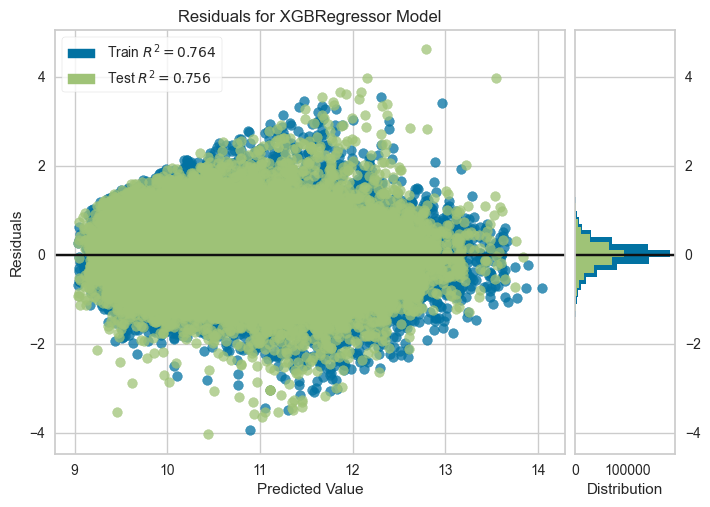

   -> Generating Prediction Error Plot...


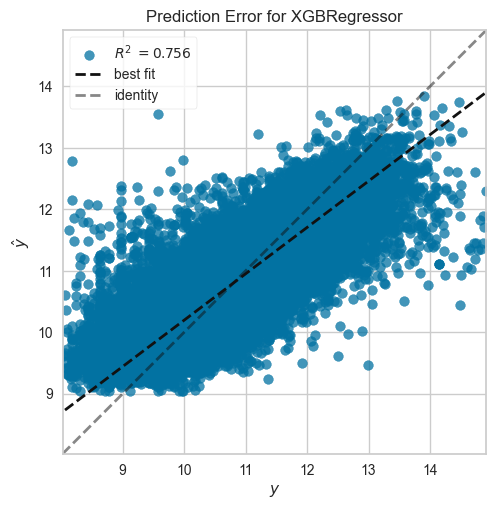

   -> Plots generated and displayed.


In [41]:

# =============================================================================
# NEW: STEP 7 - EVALUATE ON HOLD-OUT SET (RMSE, R2, etc.)
# =============================================================================
print("\n7. Evaluating Best Model on Hold-Out Set...")
# This runs prediction on the 30% hold-out set and prints the scoreboard (RMSE, R2, etc.)
hold_out_metrics = predict_model(best_model)
print(hold_out_metrics.head()) # Display the first few rows of predictions & metrics

# =============================================================================
# NEW: STEP 8 - PLOT RESIDUALS
# =============================================================================
print("\n8. Generating Diagnostic Plots (using Hold-Out Set)...")

# Plot 1: Residuals vs. Predicted
# This is the "random cloud" plot.
print("   -> Generating Residuals Plot...")
plot_model(best_model, plot='residuals') 
# Removed 'save=True' to display plot directly in the notebook

# Plot 2: Actual vs. Predicted (Error Plot)
# This shows how far predictions are from the perfect y=x line.
print("   -> Generating Prediction Error Plot...")
plot_model(best_model, plot='error')
# Removed 'save=True' to display plot directly in the notebook

print("   -> Plots generated and displayed.")
